In [16]:
using LinearAlgebra
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt
using SpecialFunctions
using HDF5

## Quantum system

In [17]:
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.106.120402

# order: |1>, |2>, |3>
H0 = Matrix(Diagonal([1, 1.1, 1.2]))


# Control Hamiltonian
V = [
    0 0 1;
    0 0 1;
    1 1 0
]


3×3 Matrix{Int64}:
 0  0  1
 0  0  1
 1  1  0

## Chebyshve polynomial approximation for $\exp(\Delta t \Omega)$

In [18]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [19]:
@polyvar x[1:2]

# final time
const T = 0.5

Δt = T / size(x)[1]

𝓤 = prod(exp_chebyshev(Δt, -im * (H0 + ξ * V), 7) for ξ in x);

## Utilities

In [20]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function propagate(x::AbstractArray)   
    #=
    Solve the equation of motion
    =#
    prod(exp(-im * Δt * (H0 + ξ * V)) for ξ in x)
end

function 𝓤_propagation(x::AbstractArray)   
    map(z -> z(x), 𝓤)
end

𝓤_propagation (generic function with 1 method)

### Define the target observable $O$ whose expectation value is to be maximized 

In [21]:
λ = [0.1, 1, 0]

@assert size(λ)[1] == size(H0)[1]
@assert λ[2] > λ[1] > λ[3]

O = Diagonal(λ)

function expectation_O(x::AbstractArray)
    #=
    The exact expectation value of O
    =#
    # |1> is the intial state
    Ψ = 𝓤_propagation(x) * [1; 0; 0]
    
    real(Ψ' * O * Ψ)
end

expectation_O (generic function with 1 method)

In [22]:
ψ = 𝓤 * [1; 0; 0]

obj = -real_poly(ψ' * O * ψ);
# obj = (1. - real_poly(ψ' * O * ψ)) ^ 2;

In [23]:
# Get the global minimum via TSSOS library
opt,sol,data = tssos_first(
    [obj; [ξ + 2.5 for ξ in x]; [-ξ + 2.5 for ξ in x]], 
    variables(obj), maxdegree(obj) ÷ 2 + 8, numeq=0; QUIET = false, solution = true,
)

#opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)

previous_sol = sol
previous_opt = opt
    
while ~isnothing(sol)
    previous_sol = sol
    previous_opt = opt
            
    opt,sol,data = tssos_higher!(data; QUIET = false, solution = true)
end
    
tssos_glob_obj_min = previous_opt
glob_min_x = previous_sol

***************************TSSOS***************************
TSSOS is launching...
Starting to compute the block structure...
------------------------------------------------------
The sizes of PSD blocks:
[276]
[1]
------------------------------------------------------
Obtained the block structure in 0.363704928 seconds. The maximal size of blocks is 276.
Assembling the SDP...
There are 1035 affine constraints.
SDP assembling time: 0.54065098 seconds.
Solving the SDP...
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1035            
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 6               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraint

2-element Vector{Float64}:
 -1.2159957467444423e-9
  1.2173373381497535e-9

In [24]:
using Plots
using LaTeXStrings

In [25]:
x_range = Vector(-2:0.1:2)

landscape_O = [expectation_O([x1, x2]) for x1 = x_range, x2 = x_range];

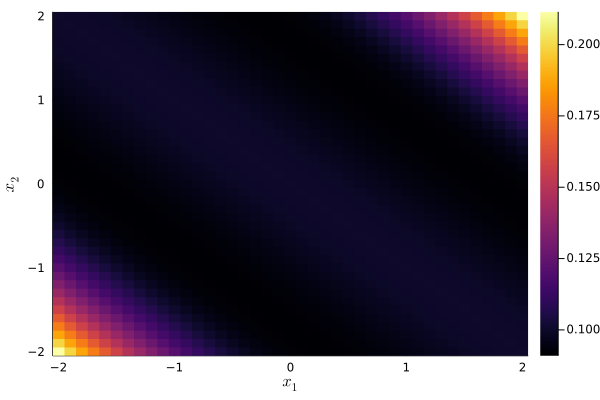

In [26]:
heatmap(x_range, x_range, landscape_O)
xlabel!(L"x_1")
ylabel!(L"x_2")

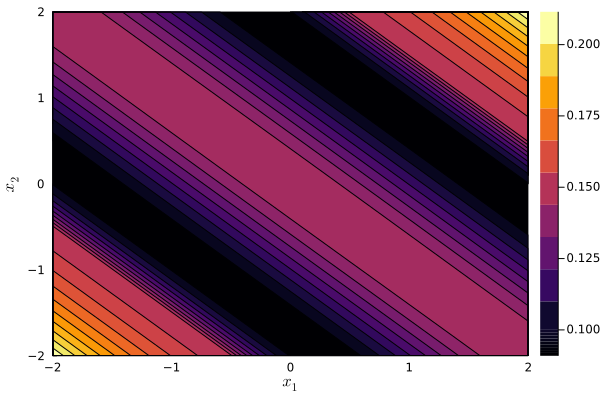

In [27]:
contourf(
    x_range, x_range, landscape_O, 
    levels=[range(minimum(landscape_O), 0.1, 10); range(0.11, maximum(landscape_O), 10)]
)
xlabel!(L"x_1")
ylabel!(L"x_2")

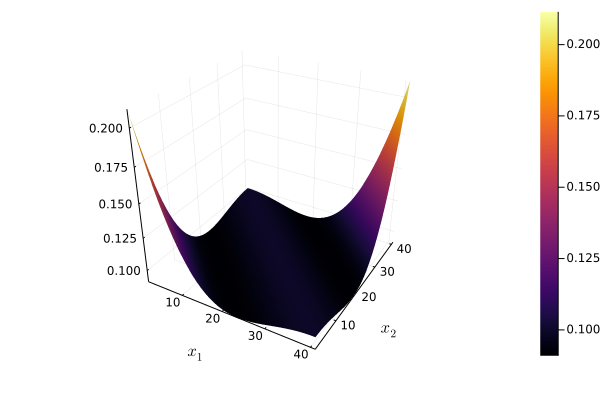

In [28]:
surface(landscape_O)
xlabel!(L"x_1")
ylabel!(L"x_2")

In [29]:
landscape_obj = [-obj([x1, x2]) for x1 = x_range, x2 = x_range];

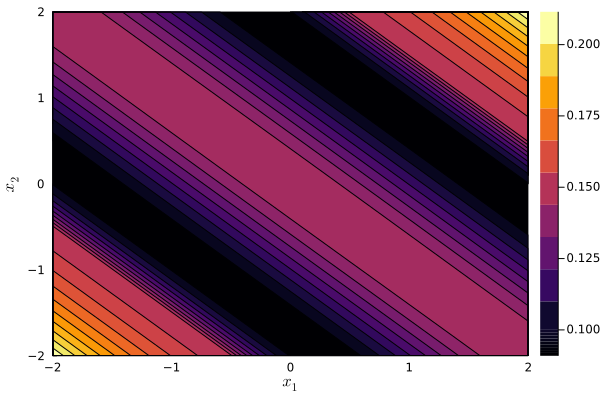

In [30]:
contourf(
    x_range, x_range, landscape_obj, 
    levels=[range(minimum(landscape_obj), 0.1, 10); range(0.11, maximum(landscape_obj), 10)]
)
xlabel!(L"x_1")
ylabel!(L"x_2")